<div class="title">Aplicaciones de Análisis &ndash; TensorFlow: Práctica</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

<div style="font-size: large; font-weight: bold; margin-left: 2em;">Nombre: ____________________________</div>

**Configuración Inicial**

In [204]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

# Enunciado

## Introducción

Se dispone de un conjunto de imágenes etiquetadas como: `cloudy`, `rain`, `shine`, y `sunrise`.

## Objetivo

<div class="qst">

* Crear un modelo con Keras que permita determinar, a partir de una imagen de test, la etiqueta correcta.
    * Se requiere una precisión mínima de entrenamiento del $94\%$. Llegado a este punto se deberá parar el entrenamiento.
    * Dada la complejidad del problema, se deberá:
        * Probar diferentes optimizadores.
        * Probar diferentes tasas de aprendizaje.
        * Variar el número de épocas, el tamaño de los *batchs*, el número de pasos por época...
        * Utilizar diferentes *callbacks* para facilitar la experimentación (por ejemplo, guardando los modelos según se va avanzando).
    * Para cada una de estas comprobaciones, se deberá dar una breve explicación de su funcionamiento y de los resultados obtenidos.

</div>

# Dependencias

In [205]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

# Esquema

El *notebook* está organizado mostrando un posible ejemplo de la ruta que se puede seguir para afrontar el problema (aunque no es estrictamente necesario seguir este orden).

Como *baseline* y punto de partida, se realiza la carga de los datos, y se entrena un modelo lineal (perceptrón de clasificación).

## Carga de Datos y Preproceso

* Cargar las imágenes.
* Preprocesar las imágenes.
    * Normalizar la escala.
    * Garantizar que el tamaño sea coherente.
* Generar nuevos ejemplos.
* Ajustar tamaño de *batch*.

In [206]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters.
rescale = 1. / 255
image_size = (150, 150)
batch_size = 32

# The image generator can help to preprocess the images.

# In training, new samples can be generated by modifying this object.
datagen_tr = ImageDataGenerator(
    rescale=rescale
)
# In test (and validation), new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=rescale
)

# The data is already partitioned by folders, each class is in a different subfolder.
# The following function returns iterators to each dataset.
data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size
)
data_va = datagen_te.flow_from_directory(
    "data/validation/",
    target_size=image_size,
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


* Ejemplo del conjunto de datos.

Batch shape (input):  (32, 150, 150, 3)
Batch shape (target): (32, 4)


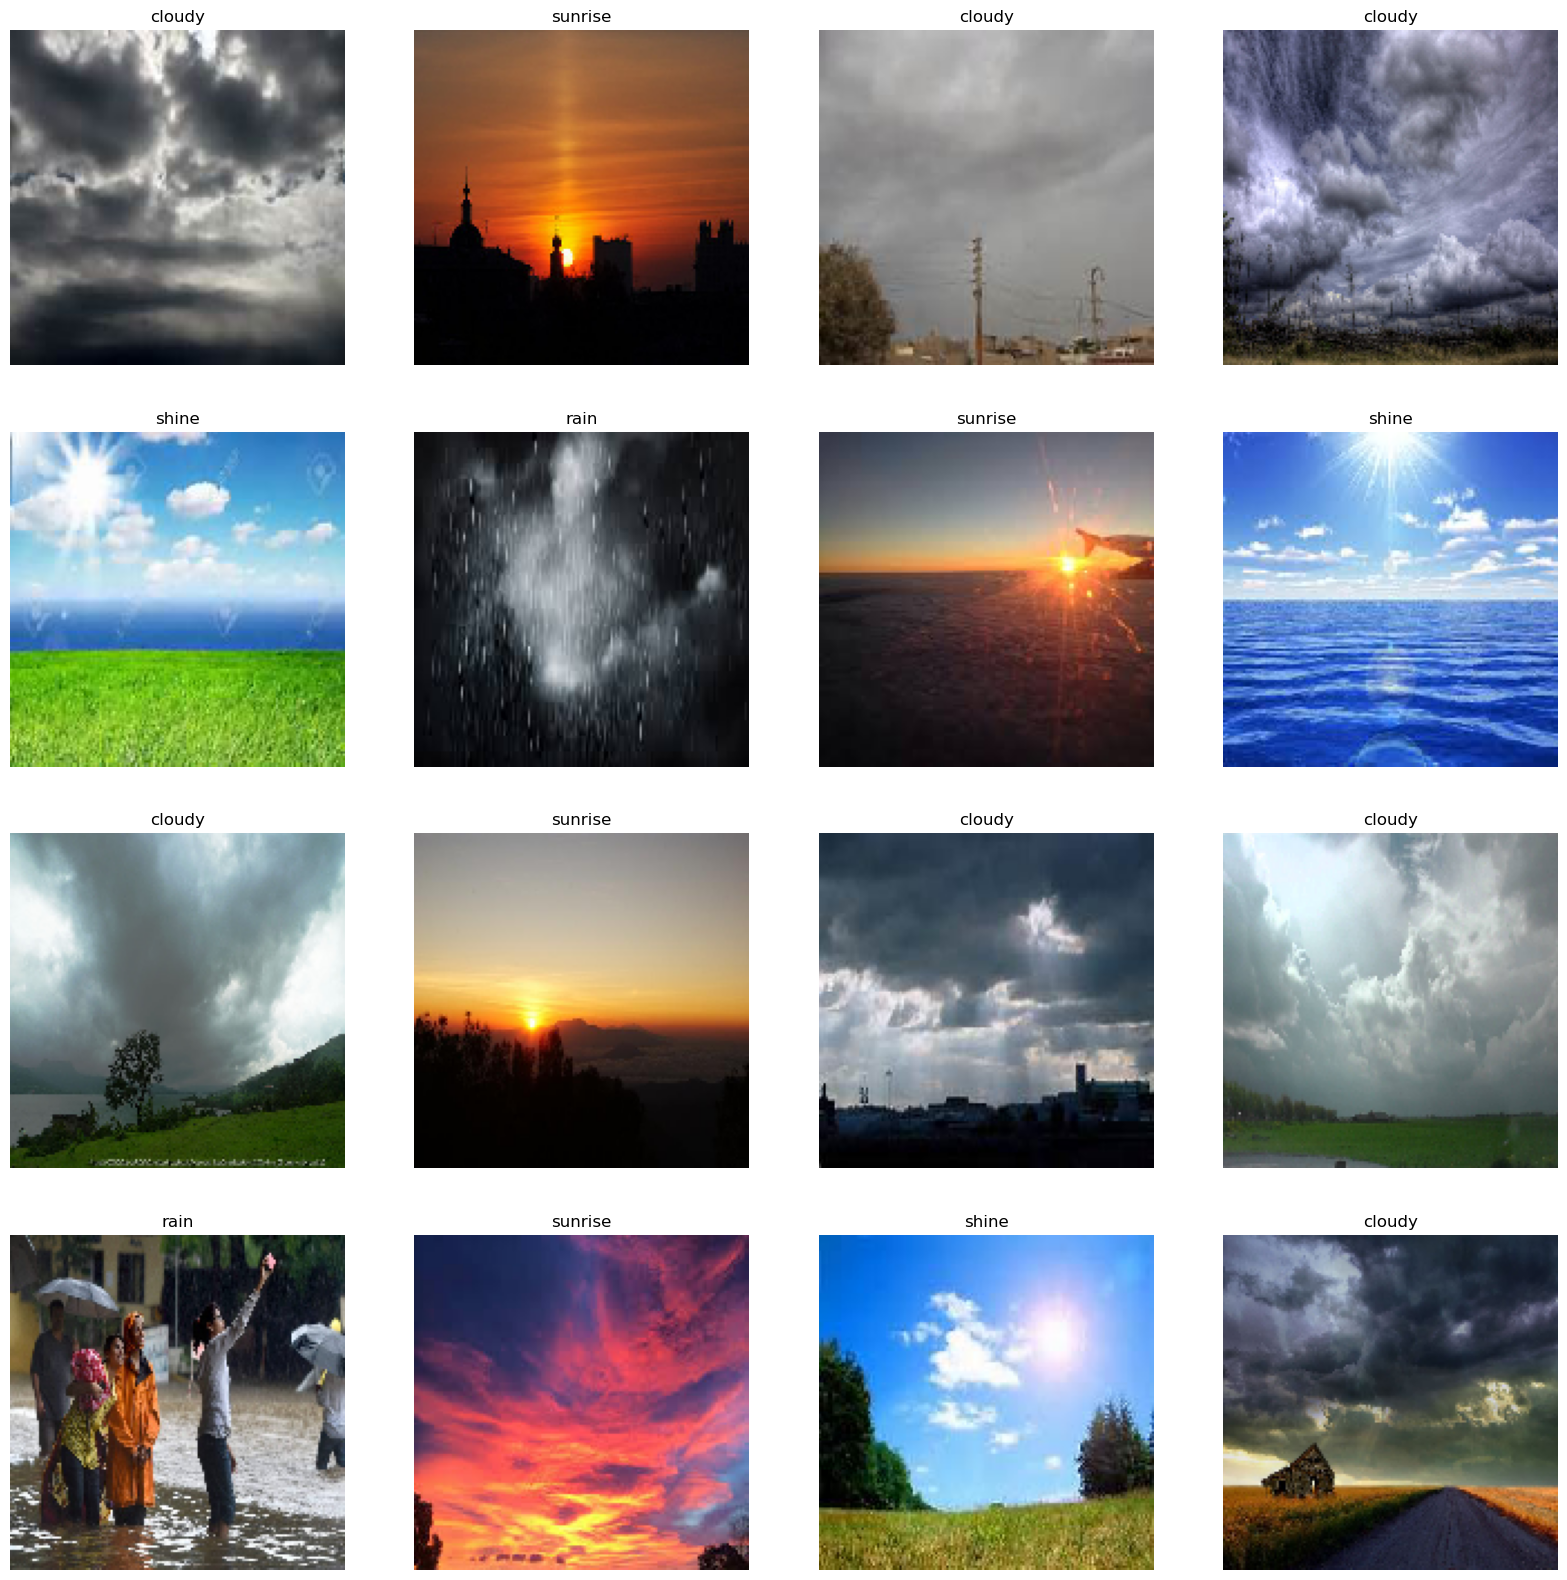

In [207]:
classes = [k for k, v in data_tr.class_indices.items()]

n_rows = 4
n_cols = 4

for batch_x, batch_y in data_tr:
    print("Batch shape (input): ", batch_x.shape)
    print("Batch shape (target):", batch_y.shape)

    plt.figure(figsize=(20, 20))
    for c, x, y in zip(range(len(batch_x)), batch_x, batch_y):
        if c == n_rows * n_cols:
            break

        plt.subplot(n_rows, n_cols, c + 1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(classes[np.where(y)[0][0]])

    plt.show()
    break

## Definición del Modelo

* Ajustar arquitectura.

In [208]:
# A simple perceptron is defined in this case.
model = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),

        # Data augmentation: estamos creando mas ejemplos que pasarle a la red para entrenar mas escenarios
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.BatchNormalization(),

        # Capas ocultas
        keras.layers.Conv2D(128, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Conv2D(256, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Flatten(),
        
        # Eliminamos las conexiones entre la capa de activación y la de salida para evitar overfitting
        keras.layers.Dropout(0.5),
        
        # Capa de salida
        keras.layers.Dense(4, activation="softmax")
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 147, 147, 128)     6272      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 128)      0         
 2D)                                                             
                                                      

## Compilación del Modelo

* Ajustar optimizador.
* Ajustar tasa de aprendizaje.

In [209]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Entrenamiento del Modelo

* Definir *callbacks*.
* Ajustar número de épocas.
* Ajustar el número de pasos por época.

In [210]:
# Creamos un callback customizado que pare cuando la val_accuracy > 94%

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [211]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    MyThresholdCallback(threshold=0.94)
]

history = model.fit(
    data_tr,
    validation_data=data_va,
    epochs=epochs,
    #steps_per_epoch = 20,
    callbacks=callbacks
)

Epoch 1/25
29/29 [==============================] - 14s 423ms/step - loss: 0.8912 - accuracy: 0.6633 - val_loss: 0.6523 - val_accuracy: 0.6937
Epoch 2/25
29/29 [==============================] - 10s 331ms/step - loss: 0.4784 - accuracy: 0.8278 - val_loss: 0.5417 - val_accuracy: 0.8378
Epoch 3/25
29/29 [==============================] - 10s 326ms/step - loss: 0.3850 - accuracy: 0.8589 - val_loss: 0.6665 - val_accuracy: 0.7117
Epoch 4/25
29/29 [==============================] - 10s 324ms/step - loss: 0.5035 - accuracy: 0.8333 - val_loss: 0.3629 - val_accuracy: 0.8739
Epoch 5/25
29/29 [==============================] - 9s 318ms/step - loss: 0.3776 - accuracy: 0.8711 - val_loss: 0.3557 - val_accuracy: 0.8739
Epoch 6/25
29/29 [==============================] - 9s 318ms/step - loss: 0.3113 - accuracy: 0.8878 - val_loss: 0.2703 - val_accuracy: 0.9009
Epoch 7/25
29/29 [==============================] - 9s 318ms/step - loss: 0.3055 - accuracy: 0.9067 - val_loss: 0.3726 - val_accuracy: 0.8468
Ep

## Evaluación del Resultado

* Analizar los errores en entrenamiento y test finales.
* Analizar la evolución de los errores durante el entrenamiento, tanto sobre el conjunto de entrenamiento como sobre el de validación.
* Comprobar el resultado sobre algunas imágenes de forma manual.

In [212]:
[loss, acc] = model.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 94.74%


## Testeo de predicciones del modelo

In [228]:
def cast_to_pretty_class(predictions):
    predicted_class_indices=np.argmax(predictions,axis=1)
    labels = (data_te.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    return predictions

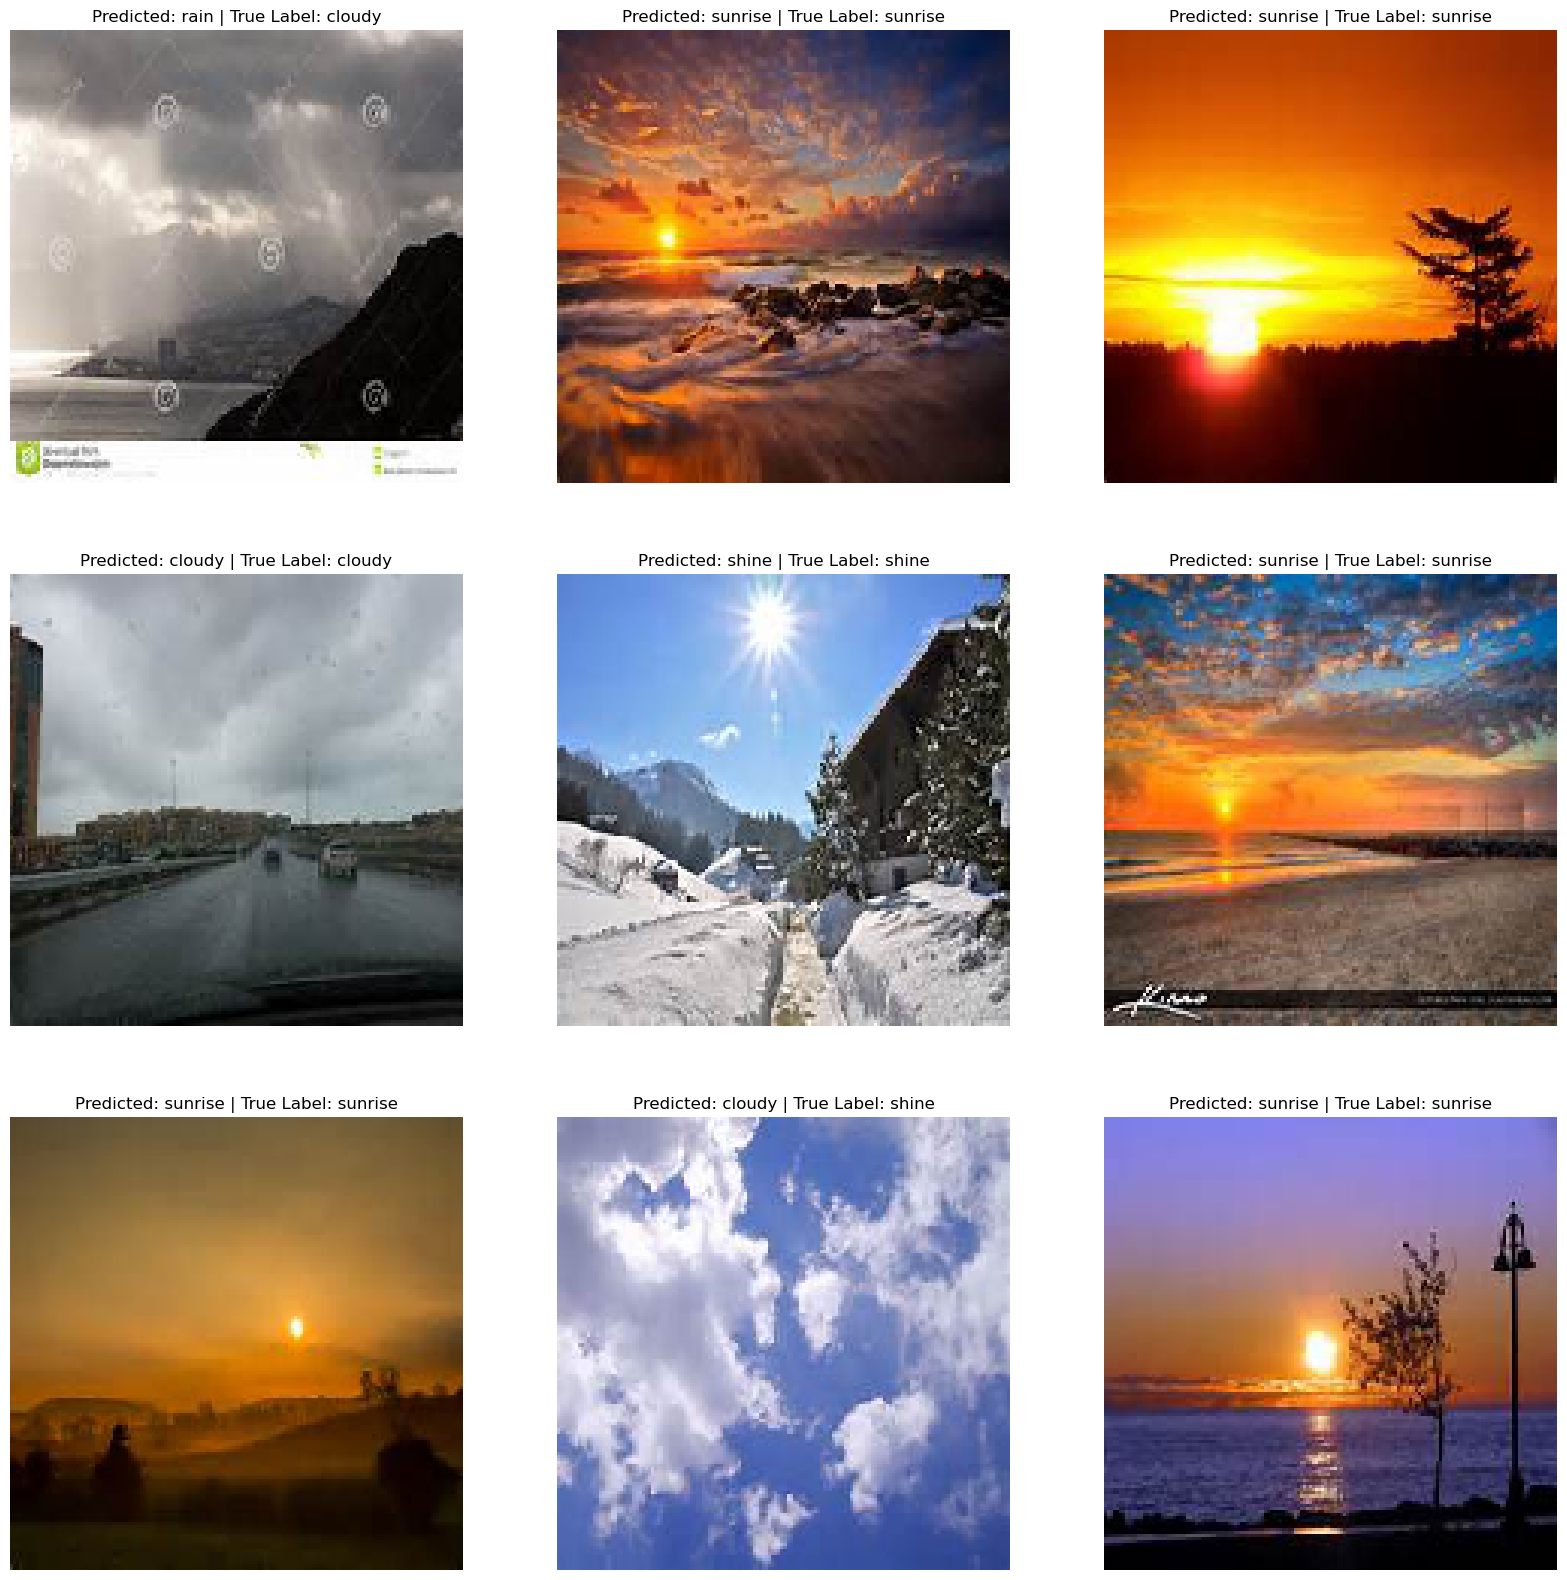

In [272]:
BATCH_INDEX = 0 # get all the batchs
IMG_OR_LBL = 0 # 0 to get the imgs 1 to get de labels
INDEX_IN_BATCH = 0 # get the nth element in the batch (depending on the value you give to the IMG_OR_LBL, it will give you the image or de true label)

# plt.imshow(data_te[BATCH_INDEX][IMG_OR_LBL][INDEX_IN_BATCH])

test_images = data_te[BATCH_INDEX][0]
test_labels = data_te[BATCH_INDEX][1]

n_rows = 3
n_cols = 3

samples_index = np.random.choice(range(32), n_rows*n_cols, replace=False)

plt.figure(figsize=(20, 20))
j=0
for i in samples_index:
    image_test = test_images[i]
    true_label = list(data_te.class_indices.keys())[np.argmax(test_labels[i],axis=0)]
    img = (np.expand_dims(image_test,0))
    predict_single = model.predict(img, verbose=0)

    plt.subplot(n_rows, n_cols, j + 1)
    plt.imshow(x)
    plt.axis("off")
    plt.title("Predicted: " + cast_to_pretty_class(predict_single)[0] + " | True Label: " + true_label)

    plt.imshow(image_test)
    j+=1

plt.show()